In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import random
import math

In [2]:
pd.options.display.max_rows = 2000

In [3]:
# database_type = input('What data set wanna use: Small(0), Big(1)')
# if(int(database_type)):
#     ratings_type = 'ratings.csv'
# else:
#     ratings_type = 'ratings_small.csv'

movie_database = pd.read_csv('./notebooks/ml-latest-small/movies.csv')
# users_ratings = pd.read_csv('Data/' + ratings_type)
users_ratings = pd.read_csv('./notebooks/ml-latest-small/ratings.csv')
movie_database.head()
# users_ratings.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movie_database =  movie_database.rename(columns={'id':'movieId'})

# Get the total number of users and movies
num_users = len(pd.unique(users_ratings['userId']))
num_movies = len(pd.unique(movie_database['movieId']))

print("Total number of movies: " + str(num_movies))
print("Total number of users: " + str(num_users))
print(users_ratings.shape)

Total number of movies: 9742
Total number of users: 610
(100836, 4)


In [5]:
'''
Alg:
1. Get userId list list_user
2. Get movieId list list_movie
3. For each user:
    a. Get ratings by user
    b. For each index of ratings in users_ratings dataframe:
        i. Get movieid index (column index) in ratings['movieId']
        ii. Append (user, movie, rating) to output list
4. Returns 3-tuple (output_list, list_user, list_movie)
'''
def get_user_item_pairs():
    list_userId = np.array(pd.unique(users_ratings['userId']))
    list_movieId = np.array(pd.unique(movie_database['movieId']))
    movie_index_list = pd.Index(movie_database['movieId'])
    output_list = []
    # index by user
    for user_index in np.arange(0, len(list_userId)):
        # associated user_id with user
        user_id = list_userId[user_index]
        # ratings by user
        ratings = users_ratings[users_ratings['userId'] == user_id]
        # for each row index associated with user
        for index in ratings.index:
            # get movie id for finding movie index
            movie_id = users_ratings['movieId'].iloc[index]
            # get movie index to place in list
            movie_index = movie_index_list.get_loc(movie_id)#movie_database['movieId'].loc[movie_id]
            # get rating
            rating = users_ratings['rating'].iloc[index]
            output_list.append((user_index, movie_index, rating))
    return (np.array(output_list, dtype='i4,i4,i4'), list_userId, list_movieId)
#     return (np.array(output_list, dtype=[('user_index', '<i4'), ('movie_index', '<i4'), ('rating', '<i4')]), list_userId, list_movieId)
'''
Input:
    S is a collection of 3-tuples (user, movie, rating)
        user is the index of the user in list_userId
        movie is the index of the movie in list_movieId
        rating is the corresponding rating
    Output: mxn feedback matrix
        m is the length of list_userId
        n is the length of list_movieId
        Entry (i, j) is nonzero if list_userId[i] reviewed list_movieId[j]
'''
def build_feedback_matrix(S, list_userId, list_movieId):
    m = list_userId.shape[0]
    n = list_movieId.shape[0]
    F = np.zeros((m, n))
    for (user_index, movie_index, rating) in S:
        F[user_index, movie_index] = rating
    return F

def data_split(S, split=.5):
    S_perm = np.copy(S)
    np.random.shuffle(S_perm)
    l = S_perm.shape[0]
    train_index = int(l * split)
    train = S_perm[:train_index];
    test = S_perm[train_index:]
    return(train, test)

'''
Train/Validation/Test split for data given by S.
Default split is 40/40/20
'''
def train_validation_test_split(S, train_prop=.4, validation_prop=.4, test_prop=.2):
    if (train_prop + validation_prop + test_prop != 1):
        raise Exception
    (pseudo_train, test) = data_split(S, split=(train_prop+validation_prop))
    (train, validation) = data_split(pseudo_train, split=(train_prop / (train_prop + validation_prop)))
    return (train, validation, test)

'''
K-fold cross validation.
'''
def k_foldCV(S, k=10):
    S_perm = np.copy(S)
    np.random.shuffle(S_perm)
    N = S_perm.shape[0]
    size = int(N / k)
    r = N % k
    folds = []
    index = 0
    for i in range(k):
        if r > 0:
            folds.append(S_perm[index:(index+size + 1)])
            r = r - 1
            index = index + size + 1
        else:
            folds.append(S_perm[index:(index+size)])
            index = index + size
    return np.array(folds)

In [6]:
(user_item_rating, list_userId, list_movieId)  = get_user_item_pairs()

In [7]:
user_item_rating

array([(  0,    0, 4), (  0,    2, 4), (  0,    5, 4), ...,
       (609, 9462, 5), (609, 9463, 5), (609, 9503, 3)],
      dtype=[('f0', '<i4'), ('f1', '<i4'), ('f2', '<i4')])

In [8]:
(train_data, validation_data, test_data) = train_validation_test_split(user_item_rating)

In [9]:
# # Build an NxM feedback matrix, N= Users, M= Movies
# F_train = build_feedback_matrix(train, list_userId, list_movieId)
# F_validation = build_feedback_matrix(validation, list_userId, list_movieId)
# F_test = build_feedback_matrix(test, list_userId, list_movieId)

In [10]:
# sns.heatmap(F_train)

In [11]:
# sns.heatmap(F_validation)

In [12]:
# sns.heatmap(F_test)

In [13]:
def calc_loss(E):
    return np.linalg.norm(E, ord='fro')**2


In [14]:
'''
Batch gradient descent algorithm.
(Runtime currently not optimized for sparse matrices.)
Our update equations are defined as
U <- U + alpha* EV
V <- V + alpha E'U

where E = F - UV' is the residual matrix
'''
def gradient_descent(F, alpha=0.0005, K=50, d=2):
    m = F.shape[0] # Number of users in feedback matrix
    n = F.shape[1] # Number of items in feedback matrix
    U = np.random.rand(m, d)
    V = np.random.rand(n, d)
    # Sanity check: we keep Frobenius norm at each step to measure our
    # loss wrt the objective function
    cost = []
    # Stop condition is currently not relative to convergence,
    # but a fixed number of iterations
    for i in np.arange(1, K):
        E = F - (U @ V.T) # Residual matrix
        iter_cost = calc_loss(E)
        cost.append(iter_cost)
        # Intermediate U and V to insure simultaneous step
        U_new = U + (alpha * (E @ V))
        V_new = V + (alpha * (E.T @ U))
        U = U_new
        V = V_new
    
    return (U, V, cost)

'''
Wrapper that takes in feedback matrix data as a
list of 3-tuples (row, col, rating). Written to
help with cross validation
'''
def train(S, list_userId, list_movieId, alpha, K, d):
    F_train = build_feedback_matrix(S, list_userId, list_movieId)
    return (F_train, gradient_descent(F_train, alpha, K, d))

In [15]:
'''
Calculate the MSE of F_hat with respect to F
S is a list of 3-tuples (i, j, rating)
We calculate the MSE over cells (i, j) found in S.
'''
def MSE(S, F, F_hat):
    # size of MSE calculation
    N = S.shape[0]
    mse = 0
    for (row, col, r) in S:
        residual = F_hat[row, col] - F[row, col]
        mse = mse + (residual**2)
    mse = mse / N
    return mse

'''
Calculate the RMSE of F_hat with respect to F
S is a list of 3-tuples (i, j, rating)
We calculate the RMSE over cells (i, j) found in S.
'''
def RMSE(S, F, F_hat):
    return math.sqrt(MSE(S, F, F_hat))

In [16]:
folds = k_foldCV(train_data, k=5)

accuracy_train = []
accuracy_validation = []
for i in range(len(folds)):
    holdout = folds[i]
    selector = [j for j in range(len(folds)) if j != i]
    train_folds = folds[selector]
    train_set = np.concatenate(train_folds)
    (F_train, (U, V, cost)) = train(train_set, list_userId, list_movieId, alpha=0.00005, K=50, d=2)
    F_hat = U @ V.T
    rmse_train = RMSE(train_set, F_train, F_hat)
    rmse_validation = RMSE(holdout, F_train, F_hat)
    accuracy_train.append(rmse_train)
    accuracy_validation.append(rmse_validation)

print(accuracy_train)
print(accuracy_validation)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[3.468311475705137, 3.471221019039104, 3.4684927167627966, 3.472265881794665, 3.4690629885296294]
[0.08468911219479458, 0.0856554968076157, 0.08499775787015439, 0.08701008473858131, 0.08874562841062218]


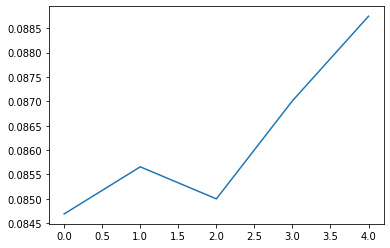

In [26]:
# plt.plot(accuracy_train)
plt.plot(accuracy_validation)

In [18]:
U, V, cost = gradient_descent(F_train, .00005, 500, 4)

In [19]:
min(cost)

392925.42442291795

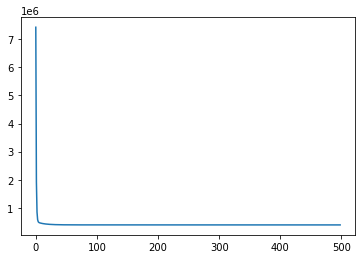

In [20]:
plt.plot(cost)

<AxesSubplot:>

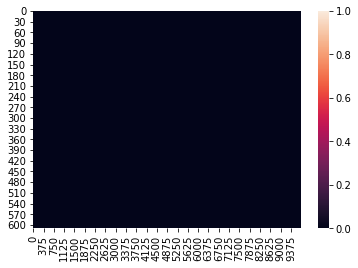

In [21]:
F_approx = U@V.T
sns.heatmap(np.round(F_approx))

In [22]:
def compare(F, F_approx, row, col):
    return_str = 'F_({i},{j}): {f}\tUV\'_({i},{j}): {fhat}\n'.format(i=row,j=col,f=F[row,col],fhat=F_approx[row,col])
    return return_str

In [23]:
for j in np.arange(0, F.shape[0]+1):
    print(compare(F, F_approx, 460, j))

NameError: name 'F' is not defined

In [ ]:
MSE(train, F, np.round(F_approx))

In [ ]:
RMSE(train, F, np.round(F_approx))